In [1]:
import xmlrpc.client
from collections import Counter
from itertools import chain
from string import ascii_lowercase
from collections import defaultdict
import csv

import requests
from piwheels.format import canonicalize_name
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
client = xmlrpc.client.ServerProxy('https://pypi.org/pypi')

def get_pypi_packages():
    return {canonicalize_name(p) for p in client.list_packages()}

In [3]:
def get_pypi_versions(pkg):
    url = f"https://pypi.org/pypi/{pkg}/json"
    r = requests.get(url)
    try:
        r.raise_for_status()
        return set(r.json()['releases'].keys())
    except requests.HTTPError as exc:
        print(exc.response.status_code)
    except Exception as exc:
        print(repr(exc))
    return None

In [4]:
def bar_from_counter(c, limit=None, x_rotation='horizontal', title='', xlabel='', ylabel='', save=None):
    mc = c.most_common()
    if limit is not None:
        mc = mc[:limit]
    x = [char for char, n in mc]
    y = [n for char, n in mc]

    plt.bar(x, y, width=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(x, rotation=x_rotation)
    plt.ylabel(ylabel)
    if save:
        plt.savefig(save + '.png')

In [5]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f"{pct:1.1f}%" if pct > 4 else ''
    return my_autopct

def pie_label(label, v, c):
    total = sum(c.values())
    pc = 100 * (v / total)
    return label if pc > 1 else ''

def pie_from_counter(c, title='', save=None):
    labels = [pie_label(lb, val, c) for lb, val in c.most_common()]
    values = [val for lb, val in c.most_common()]

    plt.pie(values, labels=labels, autopct=make_autopct(values))
    plt.title(title)
    
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    if save:
        plt.savefig(save + '.png')

In [6]:
def bar_from_counter_with_benford(c, title='', xlabel='', ylabel='', save=None):
    mc = c.most_common()
    total = sum(c.values())
    x = [char for char, n in mc]
    y = [n / total for char, n in mc]
    benford = [0.301, 0.176, 0.125, 0.097, 0.079, 0.067, 0.058, 0.051, 0.046]

    plt.plot(range(len(benford)), benford, color='red')
    plt.bar(x, y, width=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(x)
    plt.ylabel(ylabel)
    if save:
        plt.savefig(save + '.png')

In [7]:
# either run the next four cells to get the latest data from PyPI
# OR load from CSV in the following cell

# retrieve package list from PyPI (this is quick)
packages = get_pypi_packages()

In [ ]:
# retrieve set of versions for each package
# WARNING - this takes ~48 hours to complete

package_versions = {
    pkg: get_pypi_versions(pkg)
    for pkg in packages
}

In [ ]:
# remove any packages that failed
failed = {
    pkg
    for pkg, vers in package_versions.items()
    if vers is None
}

for pkg in failed:
    package_versions.pop(pkg)

In [ ]:
# save the contents of package_versions in a CSV file for loading
with open('pypi.csv', 'w') as f:
    w = csv.writer(f)
    for pkg, vers in package_versions.items():
        for ver in vers:
            w.writerow([pkg, ver])

In [8]:
# load package versions from CSV
# WARNING - this will overwrite package_versions
# so don't execute this cell if you just waited 48 hours for it to run

package_versions = defaultdict(set)
with open('pypi.csv') as f:
    r = csv.reader(f)
    for line in r:
        pkg, ver = line
        package_versions[pkg].add(ver)

In [9]:
versions = list(chain.from_iterable(package_versions.values()))

In [10]:
print(f"{len(package_versions):,}", "packages")
print(f"{len(versions):,}", "versions")

469,408 packages
4,907,076 versions


In [11]:
longest_package_name = max(package_versions, key=lambda pkg: len(pkg))
print("package with longest name:", len(longest_package_name), "chars")
print(longest_package_name)

package with longest name: 122 chars
program-to-get-any-string-as-user-input-and-output-code-for-the-string-reverse-the-string-and-code-using-alphabet-position


In [14]:
c_package_name_len = Counter(chain([len(pkg) for pkg in package_versions]))
pl, n = c_package_name_len.most_common()[0]
print(f"most common package name length: {pl} {n:,} times")

max_len = max(c_package_name_len)
long_package_names = set()
for pkg in package_versions:
    if len(pkg) == max_len:
        longest_package = pkg
    elif len(pkg) > 80:
        long_package_names.add(pkg)
        
print("long package names:")
for pkg in sorted(long_package_names, key=lambda p: len(p)):
    print("-", pkg, len(pkg))
print(f"longest package name: {longest_package} ({max_len}) chars")

most common package name length: 8 37,866 times
long package names:
- iptv-subscription-ip-tv-subscription-iptv-premium-subscription-worldwide-channels 81
- wix-protos-ecom-shipments-localdelivery-wix-ecommerce-shipments-local-delivery-web 82
- wix-protos-multilingual-localizationimporterexporter-localization-importer-exporter 83
- certora-cli-alpha-omer-cert-945-inside-assert-the-assumptions-are-not-affect-assert-cast 88
- wix-protos-com-wix-ecom-shipments-localdelivery-wix-ecommerce-shipments-local-delivery-web 90
- testtesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttesttest 92
longest package name: program-to-get-any-string-as-user-input-and-output-code-for-the-string-reverse-the-string-and-code-using-alphabet-position (122) chars


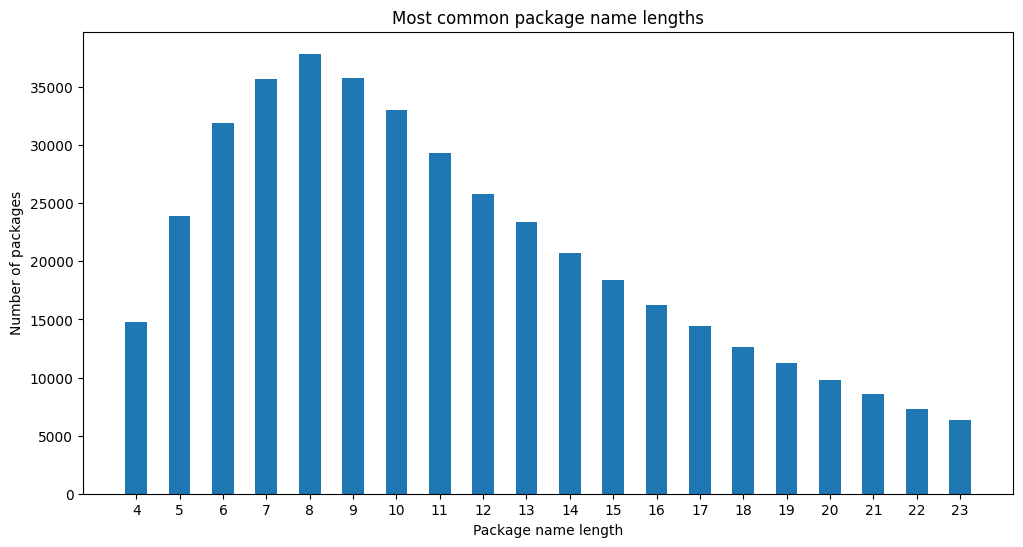

In [15]:
bar_from_counter(
    c_package_name_len,
    limit=20,
    title='Most common package name lengths',
    xlabel='Package name length',
    ylabel='Number of packages',
    save='package_name_len_bar'
)

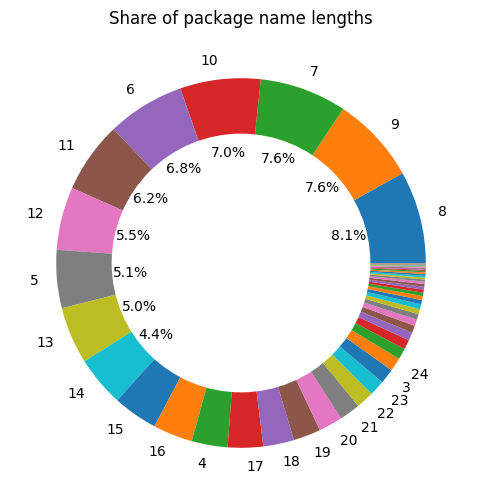

In [16]:
pie_from_counter(c_package_name_len, title='Share of package name lengths', save='package_name_len_pie')

In [17]:
package_name_len_once = {k for k, v in c_package_name_len.items() if v == 1}
print("package name lengths only occur once:")
package_name_len_once

package name lengths only occur once:


{77, 79, 80, 81, 82, 83, 88, 90, 92, 122}

In [18]:
vers = Counter(versions)
ver, n = vers.most_common()[0]
print(f"most common version: {ver} - {n:,} times")
print(f"number of distinct versions: {len(vers):,}")

most common version: 0.0.1 - 94,492 times
number of distinct versions: 413,668


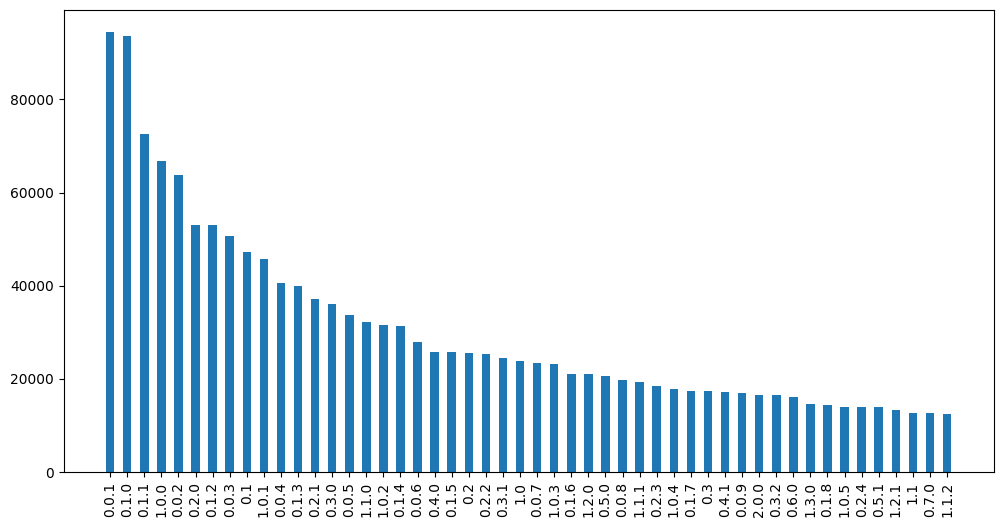

In [19]:
bar_from_counter(vers, x_rotation='vertical', limit=50)

In [20]:
ver_lens = Counter([len(v) for v in versions])
ver_len, n = ver_lens.most_common()[0]
print(f"most common version length: {ver_len} - {n:,} times ({100 * n / len(versions):.1f}%)")

max_len = max(ver_lens)
long_vers = set()
for pkg, vers in package_versions.items():
    for ver in vers:
        if len(ver) == max_len:
            longest_ver = (pkg, ver)
        elif len(ver) >= 70:
            long_vers.add((pkg, ver))
        
print("long versions:")
for pkg, ver in sorted(long_vers, key=lambda pv: len(pv[1])):
    print("-", pkg, ver, len(ver))
print(f"longest version: {longest_ver[0]} {longest_ver[1]} ({max_len}) chars")

most common version length: 5 - 2,310,319 times (47.1%)
long versions:
- softwarefabrica-django-utils 1.0dev-BZR-r113-panta-elasticworld.org-20100514074609-v4iupfyoiupd8jpx 70
- softwarefabrica-django-utils 1.0dev-BZR-r111-panta-elasticworld.org-20100228164942-7nfmukb7dc2e8ed6 70
- softwarefabrica-django-utils 1.0dev-BZR-r103-panta-elasticworld.org-20100219080001-n217vif76rnpstai 70
- softwarefabrica-django-utils 1.0dev-BZR-r115-panta-elasticworld.org-20100520155735-sf3yrsr0pvyvlm8m 70
- softwarefabrica-django-utils 1.0dev-BZR-r112-panta-elasticworld.org-20100308150938-mhesfprnhwga5won 70
- softwarefabrica-django-utils 1.0dev-BZR-r108-panta-elasticworld.org-20100223160746-362tylcagne0645h 70
- softwarefabrica-django-utils 1.0dev-BZR-r105-panta-elasticworld.org-20100219154414-9erbqfuchgedif70 70
- softwarefabrica-django-utils 1.0dev-BZR-r104-panta-elasticworld.org-20100219081117-8qu2ngmwluuab2ym 70
- softwarefabrica-django-utils 1.0dev-BZR-r107-panta-elasticworld.org-20100223155814-mz3e

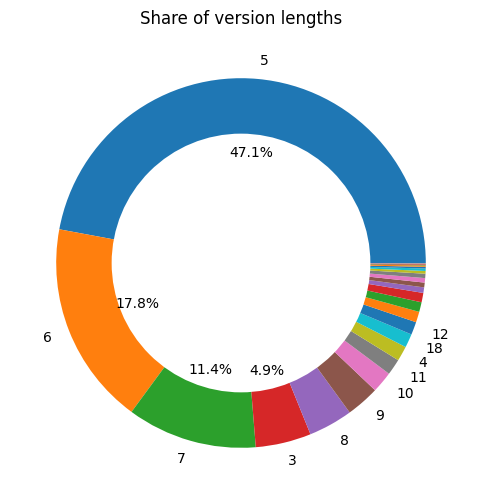

In [21]:
pie_from_counter(ver_lens, title='Share of version lengths', save='ver_lens')

In [22]:
vers_per_package = {
    pkg: len(vers)
    for pkg, vers in package_versions.items()
}
c_vers_per_package = Counter(vers_per_package.values())
pkg_most_vers = max(vers_per_package, key=lambda p: vers_per_package[p])
print(f"package with most versions: {pkg_most_vers} ({vers_per_package[pkg_most_vers]:,})")

package with most versions: spanishconjugator (5,969)


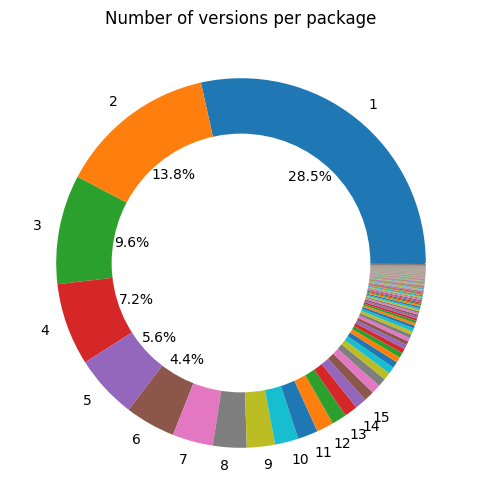

In [23]:
pie_from_counter(c_vers_per_package, title='Number of versions per package', save='vers_per_package')

In [24]:
def is_numeric(v):
    return any(d in v for d in '0123456789')

In [25]:
packages_non_numeric_versions = {
    pkg: {v for v in vers if not is_numeric(v)}
    for pkg, vers in package_versions.items()
    if len({v for v in vers if not is_numeric(v)})
}
print(f"{len(packages_non_numeric_versions):,} packages have non-numeric versions")

all_non_numeric_versions = list(chain.from_iterable(packages_non_numeric_versions.values()))
print(f"{len(all_non_numeric_versions)} versions are non-numeric")

for pkg, vers in packages_non_numeric_versions.items():
    if len(vers) > 1:
        print(pkg, vers)

161 packages have non-numeric versions
166 versions are non-numeric
pyircserver {'Alpha', 'PreAlpha'}
pycli {'devel', 'dev'}
amoi {'lol', '.lol.'}
dstufft-testpkg {'watwatwat', 'dog'}
confine-controller {'beta', 'dev'}


In [28]:
pkg_with_longest_nn_version = max(packages_non_numeric_versions, key=lambda p: max(len(v) for v in packages_non_numeric_versions[p]))
longest_version = max(packages_non_numeric_versions[pkg_with_longest_nn_version], key=lambda v: len(v))
print("package with longest non-numeric version:")
print(pkg_with_longest_nn_version, longest_version, len(longest_version), "chars")

package with longest non-numeric version:
jw-util -class.-jw.util.version.Version- 32 chars


In [27]:
packages_with_spaces_in_versions = {
    pkg: {v for v in vers if ' ' in v}
    for pkg, vers in package_versions.items()
    if len({v for v in vers if ' ' in v})
}
print(len(packages_with_spaces_in_versions), "packages with spaces in versions")

75 packages with spaces in versions


In [29]:
pkg_with_longest_spaces_version = max(packages_with_spaces_in_versions, key=lambda p: max(len(v) for v in packages_with_spaces_in_versions[p]))
longest_version = max(packages_with_spaces_in_versions[pkg_with_longest_spaces_version], key=lambda v: len(v))
print("package with longest version:")
print(pkg_with_longest_spaces_version, longest_version, len(longest_version), "chars")

package with longest version:
parallel 0.2.5 (deprecated - see pprocess) 33 chars


In [30]:
c_versions = Counter(chain.from_iterable(package_versions.values()))
v, c = c_versions.most_common()[0]
print("most common version:", v, c, "times")

most common version: 0.0.1 94492 times


In [31]:
c_num_versions = Counter(chain([len(vers) for vers in package_versions]))
v, c = c_num_versions.most_common()[0]
print("most common number of versions for a package:", v, c, "times")

most common number of versions for a package: 8 37866 times


In [32]:
c_pkg_first_letter = Counter(chain([p[0] for p in package_versions.keys()]))
for char, c in c_pkg_first_letter.most_common():
    print(char, c)

p 63526
s 40506
d 39065
c 32276
a 28715
m 27553
o 26457
t 26335
f 18394
r 16466
g 16405
b 16261
n 14674
e 14053
l 13450
i 11085
h 11021
w 10764
k 7492
j 7443
v 6575
u 5262
q 3982
z 3838
y 3790
x 3600
1 138
2 65
3 60
0 47
4 34
5 27
7 17
8 15
6 10
9 7


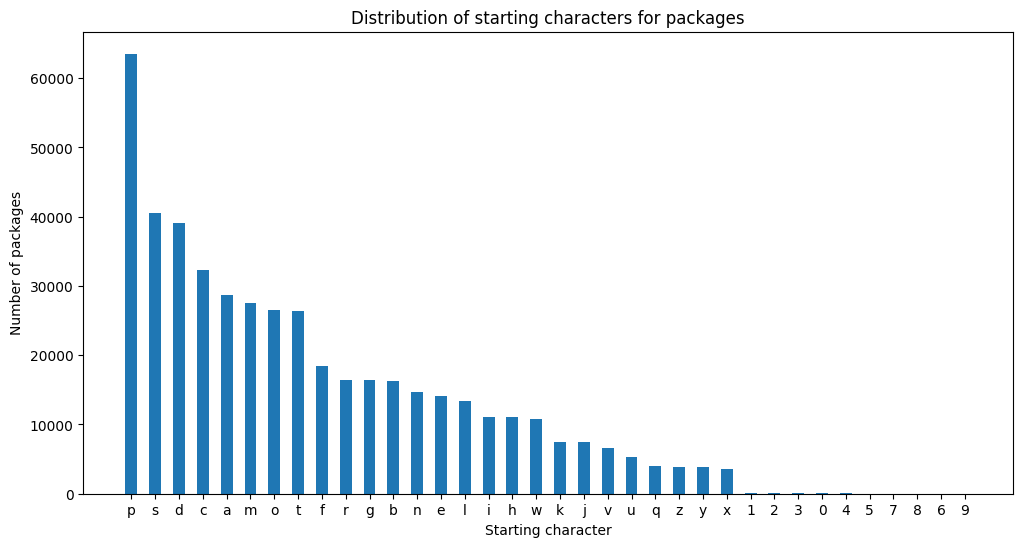

In [33]:
bar_from_counter(
    c_pkg_first_letter,
    title='Distribution of starting characters for packages',
    xlabel='Starting character',
    ylabel='Number of packages',
    save='pkg_first_letter_bar'
)

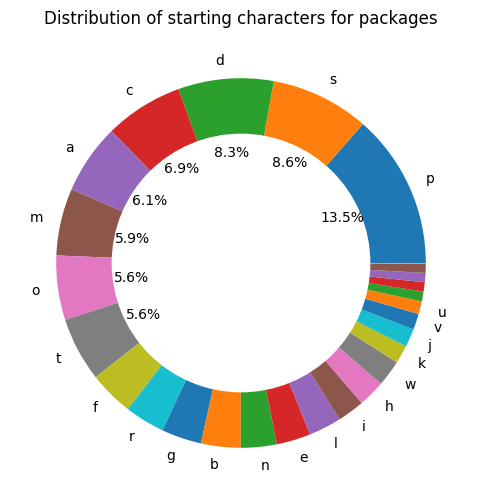

In [34]:
pie_from_counter(
    c_pkg_first_letter,
    title='Distribution of starting characters for packages',
    save='pkg_first_letter_pie'
)

In [35]:
for pkg in package_versions:
    if pkg[0] == '9':
        print(f"<li><a href='https://pypi.org/project/{pkg}'>{pkg}</a></li>")

<li><a href='https://pypi.org/project/999'>999</a></li>
<li><a href='https://pypi.org/project/9'>9</a></li>
<li><a href='https://pypi.org/project/99'>99</a></li>
<li><a href='https://pypi.org/project/99d4aa80-d846-424f-873b-a02c7215fc54'>99d4aa80-d846-424f-873b-a02c7215fc54</a></li>
<li><a href='https://pypi.org/project/908dist'>908dist</a></li>
<li><a href='https://pypi.org/project/9ja'>9ja</a></li>
<li><a href='https://pypi.org/project/91act-platform'>91act-platform</a></li>


In [36]:
c_pkg_first_two_letters = Counter(chain([p[:2] for p in package_versions.keys()]))
for chars, c in c_pkg_first_two_letters.most_common()[:5]:
    print(chars, c)

py 36671
od 16016
dj 15759
co 9571
re 6167


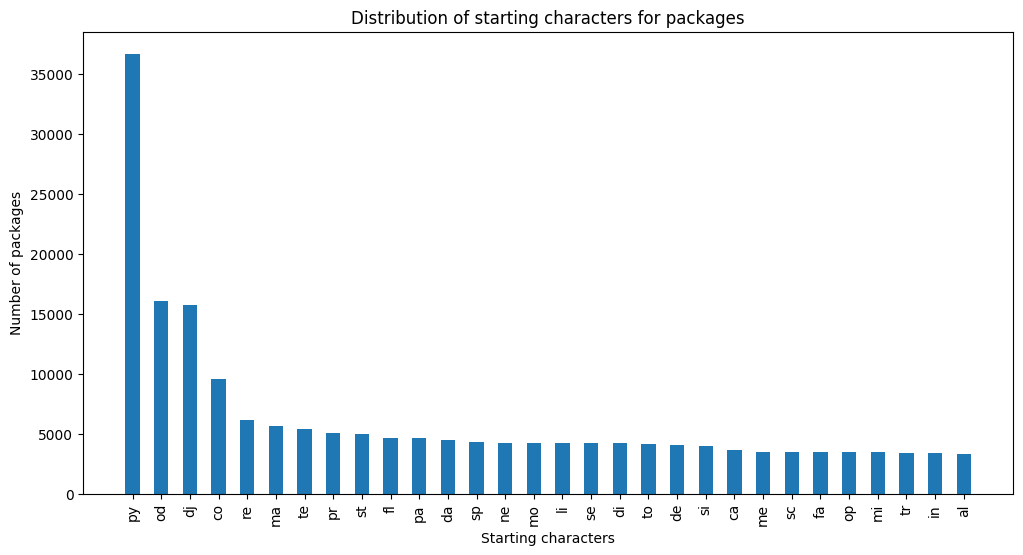

In [37]:
bar_from_counter(
    c_pkg_first_two_letters,
    limit=30,
    x_rotation='vertical',
    title='Distribution of starting characters for packages',
    xlabel='Starting characters',
    ylabel='Number of packages',
    save='pkg_first_two_letters_bar'
)

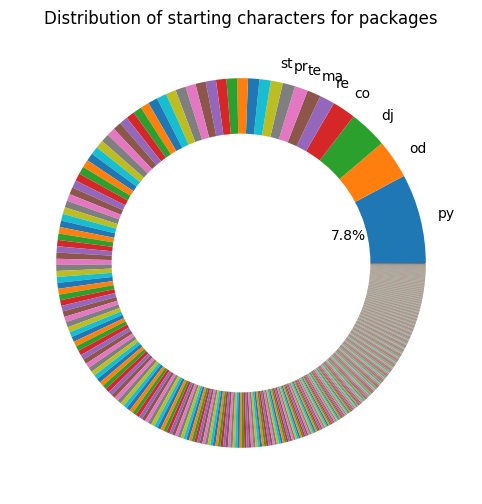

In [38]:
pie_from_counter(
    c_pkg_first_two_letters,
    title='Distribution of starting characters for packages',
    save='pkg_first_two_letters_letters_pie'
)

In [39]:
c_pkg_first_three_letters = Counter(chain([p[:3] for p in package_versions.keys()]))
for chars, c in c_pkg_first_three_letters.most_common()[:5]:
    print(chars, c)

odo 15718
dja 15063
pyt 8129
fla 3332
pro 2851


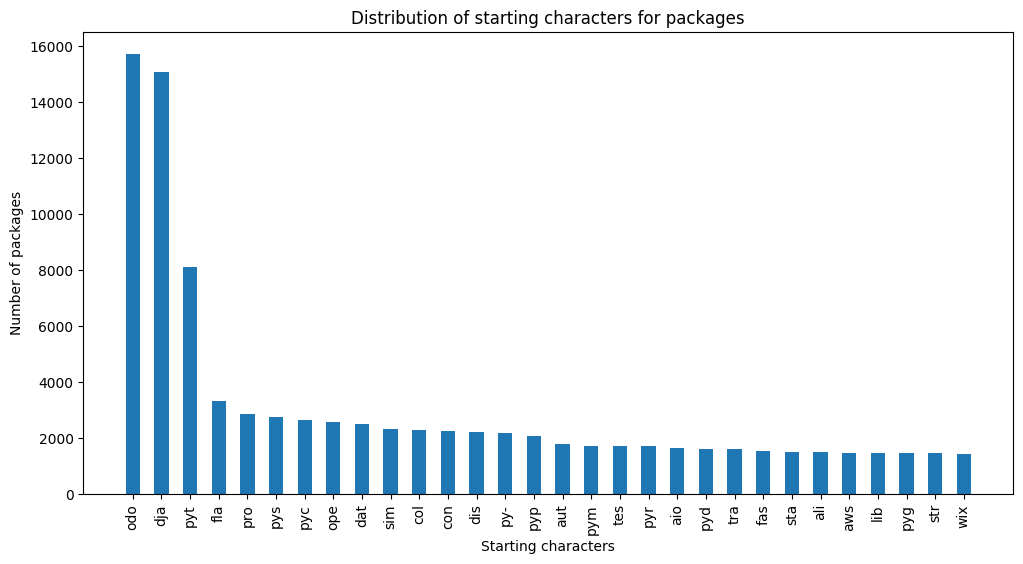

In [40]:
bar_from_counter(
    c_pkg_first_three_letters,
    limit=30,
    x_rotation='vertical',
    title='Distribution of starting characters for packages',
    xlabel='Starting characters',
    ylabel='Number of packages',
    save='pkg_first_three_letters_bar'
)

In [41]:
def get_wordlist(dict_name):
    with open(f'/usr/share/dict/{dict_name}') as f:
        return {
            word.strip()
            for word in f
            if all(c in ascii_lowercase for c in word.strip())
        }

WORDS_US = get_wordlist('american-english')
WORDS_UK = get_wordlist('british-english')

In [42]:
single_word_packages_us = {pkg for pkg in package_versions.keys() if pkg in WORDS_US}
single_word_packages_uk = {pkg for pkg in package_versions.keys() if pkg in WORDS_UK}
print(f"{len(single_word_packages_us):,} US word packages")
print(f"{len(single_word_packages_uk):,} UK word packages")

uk_eng_only_packages = single_word_packages_uk - single_word_packages_us
print(len(uk_eng_only_packages), "UK-specific package names")

13,126 US word packages
12,990 UK word packages
42 UK-specific package names


In [43]:
for pkg in sorted(uk_eng_only_packages):
    print(pkg)

acclimatise
aerofoils
aluminium
analyse
armoury
behaviour
caesium
colour
colouration
coloured
colourful
colourless
colours
connexion
cypher
decentralise
draughts
draughtsman
fibre
gramme
harbour
inflexion
labours
maths
memorised
mitre
motorise
mould
moult
mums
netts
normalise
optimisation
optimiser
organise
pyjamas
sceptre
spectre
spectres
summarise
tricolour
visualise


In [44]:
stripped_pkgs = set()
stripped_dupe_pkgs = set()
for pkg, vers in package_versions.items():
    for ver in vers:
        if ver.strip() != ver:
            stripped_pkgs.add((pkg, ver))
            if ver.strip() in vers:
                stripped_dupe_pkgs.add((pkg, ver))

In [45]:
print(f"{len(stripped_pkgs)} versions ending with whitespace:")
for pkg, ver in sorted(stripped_pkgs):
    print("-", pkg, repr(ver))

16 versions ending with whitespace:
- bugzilla '1.0\n'
- bugzilla '1.0.0\n'
- django-filtered-form '1.0.1\n'
- django-mongokit '0.2.3\n'
- docbook '1.0.11\n'
- git-plus '0.2.1.beta\n'
- lcinvestor '2.2.1\n'
- lendingclub '0.1.7\n'
- pythonwpy '0.3.0\n'
- pythonwpy '0.3.2\n'
- pythonwpy '0.3.3\n'
- pythonwpy '0.3.3.1\n'
- rabbit-qurator 'v1.0.0\n'
- rtmidi2 '0.5.2\n'
- sndfileio '0.6\n'
- thrivext '0.0.3    '


In [46]:
print(f"{len(stripped_dupe_pkgs)} versions ending with whitespace which have stripped duplicates:")
for pkg, ver in sorted(stripped_dupe_pkgs):
    print("-", pkg, repr(ver))

12 versions ending with whitespace which have stripped duplicates:
- bugzilla '1.0\n'
- bugzilla '1.0.0\n'
- django-filtered-form '1.0.1\n'
- django-mongokit '0.2.3\n'
- docbook '1.0.11\n'
- git-plus '0.2.1.beta\n'
- lcinvestor '2.2.1\n'
- lendingclub '0.1.7\n'
- pythonwpy '0.3.0\n'
- pythonwpy '0.3.3\n'
- rabbit-qurator 'v1.0.0\n'
- rtmidi2 '0.5.2\n'


In [47]:
def is_strictly_numeric(version):
    return all(char in '0123456789.' for char in version)

def digits_only(version):
    return ''.join(d for d in version if d in '123456789')

In [48]:
strictly_numeric_versions = [digits_only(v) for v in versions if is_strictly_numeric(v)]

In [49]:
numbers_from_versions = Counter(chain.from_iterable(strictly_numeric_versions))

In [50]:
numbers_from_versions.most_common()

[('1', 3829960),
 ('2', 1908103),
 ('3', 1317394),
 ('4', 855941),
 ('5', 707280),
 ('6', 609516),
 ('7', 521627),
 ('9', 500712),
 ('8', 471859)]

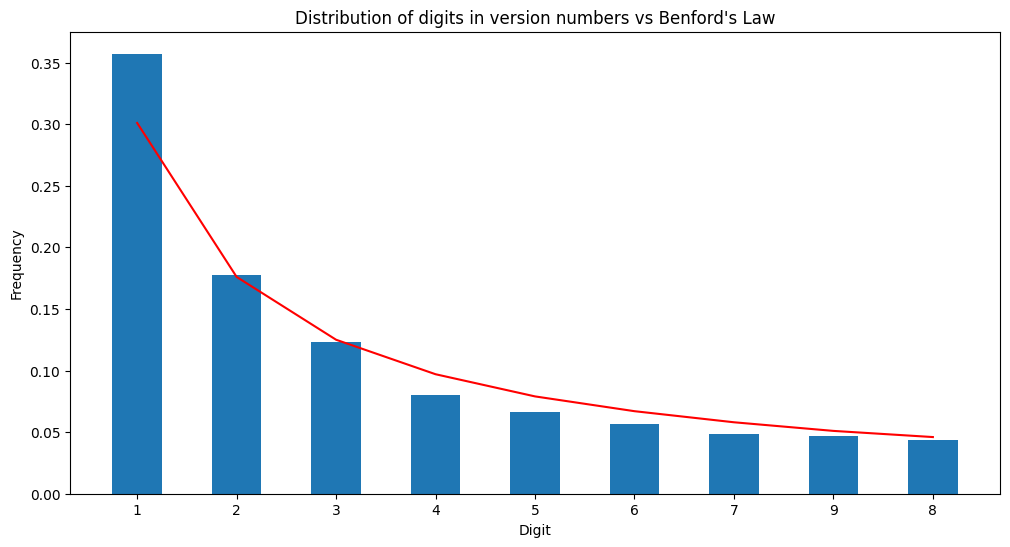

In [51]:
bar_from_counter_with_benford(
    numbers_from_versions,
    title="Distribution of digits in version numbers vs Benford's Law",
    xlabel='Digit',
    ylabel='Frequency',
    save='bar_with_benford'
)

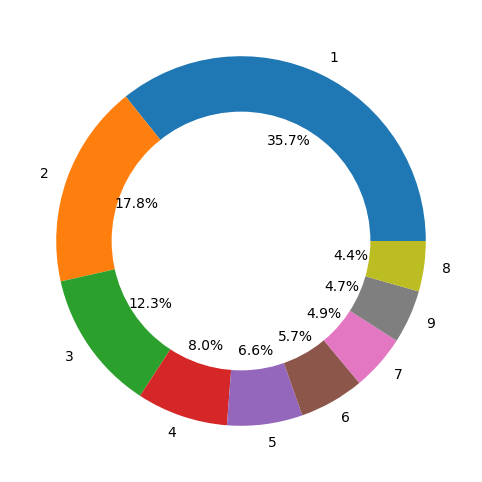

In [52]:
pie_from_counter(numbers_from_versions, save='pie')

In [53]:
strictly_numeric_versions_fd = [
    digits_only(v)[0]
    for v in versions
    if is_strictly_numeric(v)
    and digits_only(v)
]

In [54]:
numbers_from_versions_fd = Counter(strictly_numeric_versions_fd)

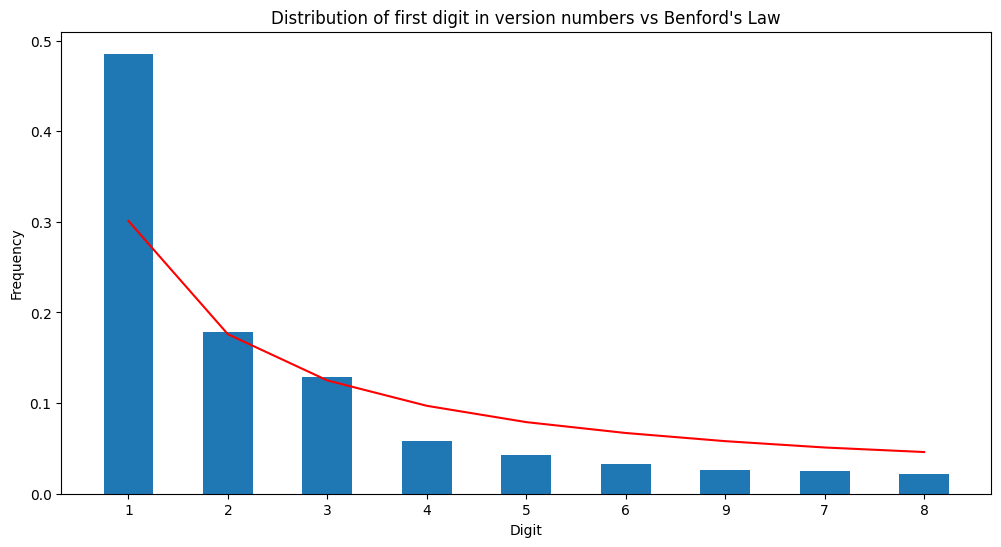

In [55]:
bar_from_counter_with_benford(
    numbers_from_versions_fd,
    title="Distribution of first digit in version numbers vs Benford's Law",
    xlabel='Digit',
    ylabel='Frequency',
    save='bar_with_benford_fd'
)